# Dogs vs Cats Image Classification using Convolutional Neural Networks

In this notebook we are going to create a model to solve the problem of finding whether the image is of a dog or a cat using Convoloutional Neural Networks (CNNs).
The dataset and problem statement is taken from Kaggle Competition: [dogs-vs-cats-redux-kernels-edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition).

## Setting up Environment and Dependencies

We are going to use Fastai library which runs on top of PyTorch. We'll also install kaggle-cli which will help us download the dataset from kaggle competition.

**Note 1: **
We need to restart the notebook kernel once these libraries are installed.

**Note 2:**
In Google Colab, you'll need to run these dependencies every single time you start the notebook.
In a dedicated machine over AWS, Google Cloud, etc. you need to do this only once as these dependencies will then be installed on the machine's disk storage.

In [ ]:
# Run these commands once to install the necessary dependencies and download the dogs and cats dataset from kaggle
!pip install torch torchvision
!pip install fastai
!pip install kaggle-cli

In [0]:
!pip install --no-cache-dir -I pillow

In [ ]:
# To download and extract the weights of Pretrained models such as Resnet.
!wget --header="Host: files.fast.ai" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.755364775.1526348522; _gid=GA1.2.1192476799.1526616713" --header="Connection: keep-alive" "http://files.fast.ai/models/weights.tgz" -O "weights.tgz" -c
!tar -xvzf weights.tgz -C /home/anubhavshrimal/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/

In [5]:
# Enter your Kaggle username and password in the below command to download the dataset
!kg download -u username -p password -c dogs-vs-cats-redux-kernels-edition

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

test.zip 100% |#####################################| Time: 0:00:06  41.0 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip 100% |####################################| Time: 0:00:12  43.5 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv 100% |########################| Time: 0:00:00 254.2 KiB/s



In [ ]:
# Create data directory and unzip training and testing data
!mkdir data && unzip test.zip -d data/
!unzip train.zip -d data

## Coding Begins:

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# NOTE: While using colab you should comment the first 2 lines of autoreload

#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libraries we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your dataset unzipped files. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. `bs` is the batch size.

`arch` is the pretrained architecture that we are using to train the CNN model. Here we are using `resnet34`.

In [4]:
PATH = "data/"
sz=224
arch=resnet34
bs=58

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed.

In [5]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [6]:
torch.backends.cudnn.enabled

True

### Data cleaning, creation and Dataset exploration:

The cat and dog images are kept in a single directory, hence we need to **create a csv file `labels.csv` in the `data/` directory** to store the file names with their corresponding label.

In [7]:
files = os.listdir(f'{PATH}train')
raw_data = {'fname': [], 'label': []}
for fname in files:
  raw_data['fname'].append(fname)
  raw_data['label'].append(fname[:3])

df = pd.DataFrame(raw_data, columns = ['fname', 'label'])
df.to_csv(f'{PATH}labels.csv', index = False)
df.head()


,fname,label
0,dog.5191.jpg,dog
1,dog.10732.jpg,dog
2,dog.2715.jpg,dog
3,dog.2627.jpg,dog
4,cat.6071.jpg,cat


In [8]:
# See how many images of cats and dogs are present in the training dataset
df.pivot_table(index='label', aggfunc=len).sort_values('fname', ascending=False)

,fname
label,
cat,12500
dog,12500


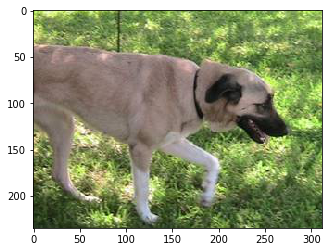

In [9]:
img = plt.imread(f'{PATH}train/{files[3]}')
plt.imshow(img);

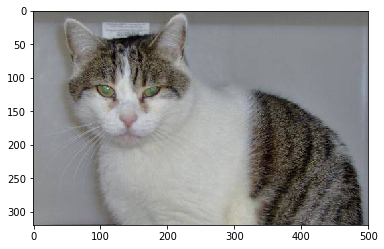

In [10]:
img = plt.imread(f'{PATH}train/{files[4]}')
plt.imshow(img);

Here is how the raw data looks like

In [11]:
img.shape

(320, 500, 3)

In [12]:
img[:4,:4]

array([[[113, 112, 108],
        [113, 112, 108],
        [113, 112, 108],
        [113, 112, 108]],

       [[113, 112, 108],
        [113, 112, 108],
        [113, 112, 108],
        [113, 112, 108]],

       [[113, 112, 108],
        [113, 112, 108],
        [113, 112, 108],
        [113, 112, 108]],

       [[114, 113, 109],
        [114, 113, 109],
        [114, 113, 109],
        [114, 113, 109]]], dtype=uint8)

As there is not validation set provided, we'll create our own `validation set` which will be 20% of the `training set`.

In [13]:
# Creating Cross Validation set
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
val_idxs

array([ 6868, 24016,  9668, ...,  4013, 21147,   695])

In [14]:
# Applying data transformations such as zooming and side mirror image to increase the data size
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)


In [15]:
fn = PATH + data.trn_ds.fnames[3];
fn

'data/train/cat.100.jpg'

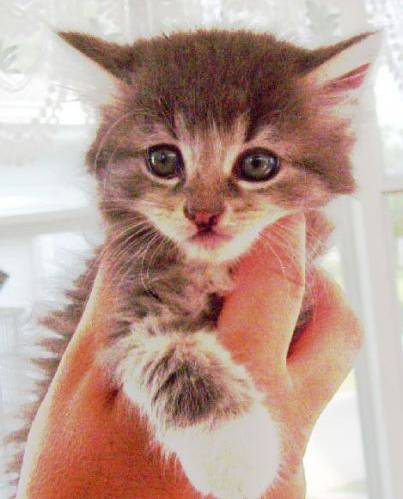

In [16]:
img = PIL.Image.open(fn);
img


Looking at the various image sizes present in the dataset. 

As most of the images are nearly of the same size and are of row size 500 we need not perform any size reductions.

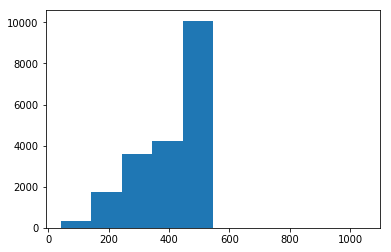

In [17]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz,col_sz = list (zip(*size_d.values()))
row_sz=np.array(row_sz); col_sz=np.array(col_sz)
plt.hist(row_sz);

(array([  47.,  224.,  532.,  931., 1052., 1572., 2495., 2097., 1393., 9655.]),
 array([ 42. ,  87.8, 133.6, 179.4, 225.2, 271. , 316.8, 362.6, 408.4, 454.2, 500. ]),
 <a list of 10 Patch objects>)

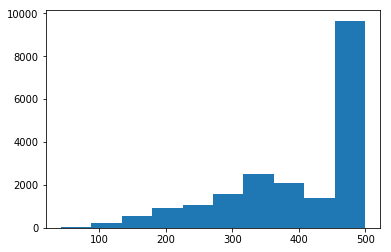

In [18]:
plt.hist(row_sz[row_sz<1000])


### Train Model:

In [19]:
# Function to give data to the model in batch sizes to avoid memory overflow
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=4,
                                        val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [20]:
# Get the data and initialize the model with pretrained architecture weights, training data and Fit the data with a learning rate of 1e-2.
data = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
learn.fit(1e-2, 2)



100%|██████████| 216/216 [01:03<00:00,  3.43it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.049191   0.02869    0.9904    
    1      0.058209   0.028823   0.9898                       



[array([0.02882]), 0.9898000059366227]

In [21]:
learn.precompute=False
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.059195   0.027121   0.9908    
    1      0.050693   0.027157   0.99                         
    2      0.050663   0.026855   0.9912                       
    3      0.058797   0.027028   0.9912                       
    4      0.041459   0.024941   0.9906                       



[array([0.02494]), 0.990600006365776]

In [22]:
# Save the intermediate model and load it.
learn.save('224_pre')
learn.load('224_pre')


In [23]:
# Train the model on larger sized images
learn.set_data(get_data(299,bs))
learn.freeze()
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.042552   0.022434   0.9918    
    1      0.043624   0.023345   0.9916                       
    2      0.045021   0.022842   0.9922                       



[array([0.02284]), 0.9922000037670136]

In [24]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047973   0.023872   0.9914    
    1      0.047988   0.025082   0.9908                       
    2      0.038025   0.024078   0.9914                       
    3      0.041755   0.024507   0.991                        
    4      0.032626   0.02355    0.992                        
    5      0.044609   0.022942   0.992                        
    6      0.046302   0.024233   0.9916                       



[array([0.02423]), 0.9916000051736832]

In [25]:
learn.save('299_pre')
learn.load('299_pre')

### Validation & Testing:

In [26]:
# Perform Test Time Augmentation to better evaluate the validation set accuracy.
# The predictions are in natural log so take its exponent to get the probabilities.
# We take the mean of all the probabilities for an image and its augmentations.

log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [27]:
accuracy_np(probs, y)

0.992

In [28]:
# Display the confusion matrix for visualizing the accuracy of the model.
from sklearn.metrics import confusion_matrix
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)

[[2493   22]
 [  18 2467]]


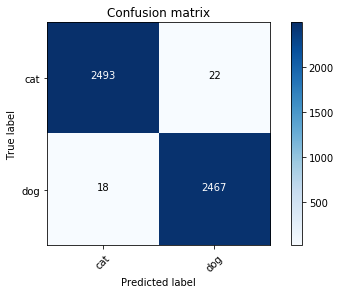

In [29]:
plot_confusion_matrix(cm, data.classes)

In [30]:
# Run the model on the test set
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(12500, 2)

In [31]:
# test_prob are the probabilities of the test images
test_probs = np.exp(log_preds_test)

# predictions are the labels of the test images 1 = dog, 0 = cat
predictions = np.argmax(test_probs, axis=1)
predictions

array([1, 1, 1, ..., 0, 1, 0])

### Kaggle Submission:

In [32]:
# Get the dog probabilities column, because kaggle competition has this as the specified format
test_probs = test_probs[:,1]
test_probs

array([1.     , 0.98921, 0.99972, ..., 0.00005, 0.9987 , 0.00006], dtype=float32)

In [33]:
# Create the sumbmission.csv file
raw_submission = {'id': [], 'label': test_probs}
for fname in data.test_ds.fnames:
  raw_submission['id'].append(fname[5:-4])

submission = pd.DataFrame(raw_submission, columns=['id', 'label'])
submission.to_csv(f'{PATH}submission.csv', index = False)
submission.head()

,id,label
0,7680,0.999999
1,5684,0.989213
2,7814,0.999722
3,4857,0.999966
4,638,0.000053


In [34]:
FileLink(f"{PATH}submission.csv")

/home/anubhavshrimal/notebooks/data/submission.csv

In [35]:
# Use your kaggle username and password to send the results on your kaggle competition and get the score.
!kg submit data/submission.csv -u username -p password -c dogs-vs-cats-redux-kernels-edition -m "Submission on Test.zip"

0.05943


## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [37]:
# Runs the function until the loss starts to increase
# keeps on increasing the learning rate until the loss starts to increase
lrf=learn.lr_find()

 80%|████████  | 277/345 [00:04<00:01, 64.78it/s, loss=0.414]


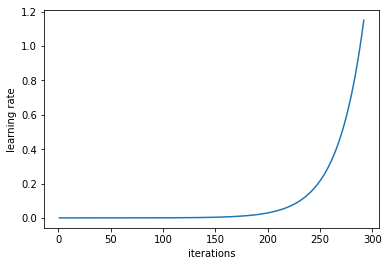

In [38]:
learn.sched.plot_lr()

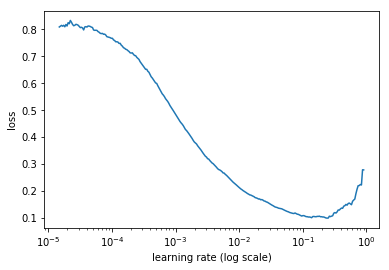

In [39]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.